# Deep Learning Methods for Text Data - Word2Vec, GloVe and FastText
- based on the "A hands-on intuitive approach to Deep Learning Methods for Text Data - Word2Vec, Glove and FastText
- https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
- added new pytorch version of word2vec instead of Keras

## The need for word embeddings
- With regard to speech or image recognition systems, all the information is already present in the form of rich dense feature vectors embedded in high-dimensional datasets like audio spectrograms and image pixel intensities. 
- However when it comes to raw text data, especially count based models like Bag of Words, we are dealing with individual words which may have their own identifiers and do not capture the semantic relationship amongst words. 
- **This leads to huge sparse word vectors for textual data and thus if we do not have enough data, we may end up getting poor models or even overfitting the data due to the curse of dimensionality**.
![](https://miro.medium.com/max/2140/1*JWjiZ0L6VmYGXGT5Ytrsng.png)
- To overcome the shortcomings of losing out semantics and feature sparsity in bag of words model based features, we need to make use of Vector Space Models (VSMs) in such a way that we can embed word vectors in this continuous vector space based on semantic and contextual similarity.
-  In fact the distributional hypothesis in the field of distributional semantics tells us that words which occur and are used in the same context, are semantically similar to one another and have similar meanings. 
- In simple terms, *‘a word is characterized by the company it keeps’*.

## The Word2Vec Model
- This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture **contextual and semantic similarity**. 
- Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate **dense word embeddings** for each word in the vector space representing that vocabulary. Usually you can specify the size of the word embedding vectors and the total number of vectors are essentially the size of the vocabulary. 
- This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.
- Two model Architectures
    - The Continuous Bag of Words (CBOW) Model
    - The Skip-gram Model
- There were originally introduced by Mikolov et al. papers, *‘Distributed Representations of Words and Phrases and their Compositionality’*  *‘Efficient Estimation of Word Representations in Vector Space’* 

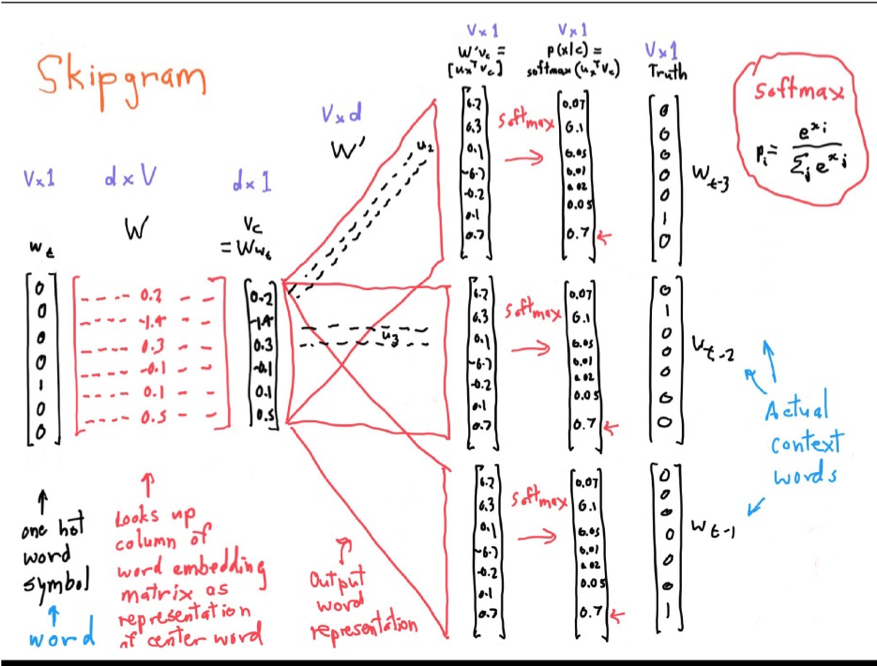

### The Continuous Bag of Words (CBOW) Model
- The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). 
- Considering a simple sentence, *“the quick brown fox jumps over the lazy dog”*, this can be pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on. Thus the model tries to predict the target_word based on the context_window words.
![](https://miro.medium.com/max/328/1*UVe8b6CWYykcxbBOR6uCfg.png)

## Robust Word2Vec Models with Gensim

- While our implementations are decent enough, they are not optimized enough to work well on large corpora. 
- The **gensim** framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. 
- We will leverage the same on Bible corpus. 
- In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.
    - size: The word embedding dimensionality
    - window: The context window size
    - min_count: The minimum word count
    - sample: The downsample setting for frequent words
- After building our model, we will use our words of interest to see the top similar words for each of them.

- Let’s now load up our other corpus based on The King James Version of the Bible using nltk and pre-process the text.

In [ ]:
# gensim 설치
pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
from nltk.corpus import gutenberg
from string import punctuation

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)



In [ ]:
bible = gutenberg.sents('bible-kjv.txt') 
#print(bible)
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

- The similar words here definitely are more related to our words of interest and this is expected given that we ran this model for more number of iterations which must have yield better and more contextual embeddings. 
- Do you notice any interesting associations?
![](https://miro.medium.com/max/1064/1*FaXo2UCuoGGWw6ryRXCEWA.png)

- Let’s also visualize the words of interest and their similar words using their embedding vectors after reducing their dimensions to a 2-D space with t-SNE.

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

- We can clearly see based on what I depicted earlier that noah and his sons are quite close to each other based on the word embeddings from our model!

## Applying Word2Vec features for Machine Learning Tasks

-  Let’s try to apply word2vec features to actual machine learning task like clustering.
- To start with, we will build a simple Word2Vec model on the corpus and visualize the embeddings.


In [ ]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

In [ ]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

In [ ]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
                              
                              
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

- Remember that our corpus is extremely small so to get meaninful word embeddings and for the model to get more context and semantics, more data helps. 
- Now what is a word embedding in this scenario? It’s typically a dense vector for each word as depicted in the following example for the word **sky**.

In [ ]:
w2v_model.wv['sky']

- Now suppose we wanted to cluster the eight documents from our toy corpus, we would need to get the document level embeddings from each of the words present in each document. 
- One strategy would be to average out the word embeddings for each word in a document. 
- This is an extremely useful strategy and you can adopt the same for your own problems. 
- Let’s apply this now on our corpus to get features for each document.


In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

- Now that we have our features for each document, let’s cluster these documents using the **Affinity Propagation** algorithm, which is a clustering algorithm based on the concept of “message passing” between data points and does not need the number of clusters as an explicit input which is often required by partition-based clustering algorithms.


In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

- We can see that our algorithm has clustered each document into the right group based on our Word2Vec features.
- Pretty neat! We can also visualize how each document in positioned in each cluster by using Principal Component Analysis (PCA) to reduce the feature dimensions to 2-D and then visualizing the same (by color coding each cluster).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

- Everything looks to be in order as documents in each cluster are closer to each other and far apart from other clusters.

## The GloVe Model

- The GloVe model stands for Global Vectors which is an unsupervised learning model which can be used to obtain dense word vectors similar to Word2Vec. 
- However the technique is different and training is performed on an aggregated **global word-word co-occurrence matrix**, giving us a vector space with meaningful sub-structures. 
- This method was invented in Stanford by Pennington et al. and I recommend you to read the original paper on GloVe, ‘GloVe: Global Vectors for Word Representation’ by Pennington et al. which is an excellent read to get some perspective on how this model works.

- The basic methodology of the GloVe model is to first create a huge word-context co-occurence matrix consisting of (word, context) pairs such that each element in this matrix represents how often a word occurs with the context (which can be a sequence of words). The idea then is to apply matrix factorization to approximate this matrix as depicted in the following figure.

![](https://miro.medium.com/max/815/1*UNtsSilztKXjLG99VXxSQw.png)

- Considering the Word-Context (WC) matrix, Word-Feature (WF) matrix and Feature-Context (FC) matrix, we try to factorize WC = WF x FC, such that we we aim to reconstruct WC from WF and FC by multiplying them. 
- For this, we typically initialize WF and FC with some random weights and attempt to multiply them to get WC’ (an approximation of WC) and measure how close it is to WC. 
- We do this multiple times using Stochastic Gradient Descent (SGD) to minimize the error. 
- Finally, the Word-Feature matrix (WF) gives us the word embeddings for each word where F can be preset to a specific number of dimensions. 
- A very important point to remember is that both Word2Vec and GloVe models are very similar in how they work. 
- Both of them aim to build a vector space where the position of each word is influenced by its neighboring words based on their context and semantics. 
- Word2Vec starts with local individual examples of word co-occurrence pairs and GloVe starts with global aggregated co-occurrence statistics across all words in the corpus.

### Weighting Function

특정 단어 간의 Co-occurrence는 다른 것들에 비해 과하게 높을 수가 있다. 그래서 Co-occurrence가 너무 큰 경우의 영향을 줄이기 위한 Weighting Function 을 사용(f(P_{ij})

#### Weighting Function
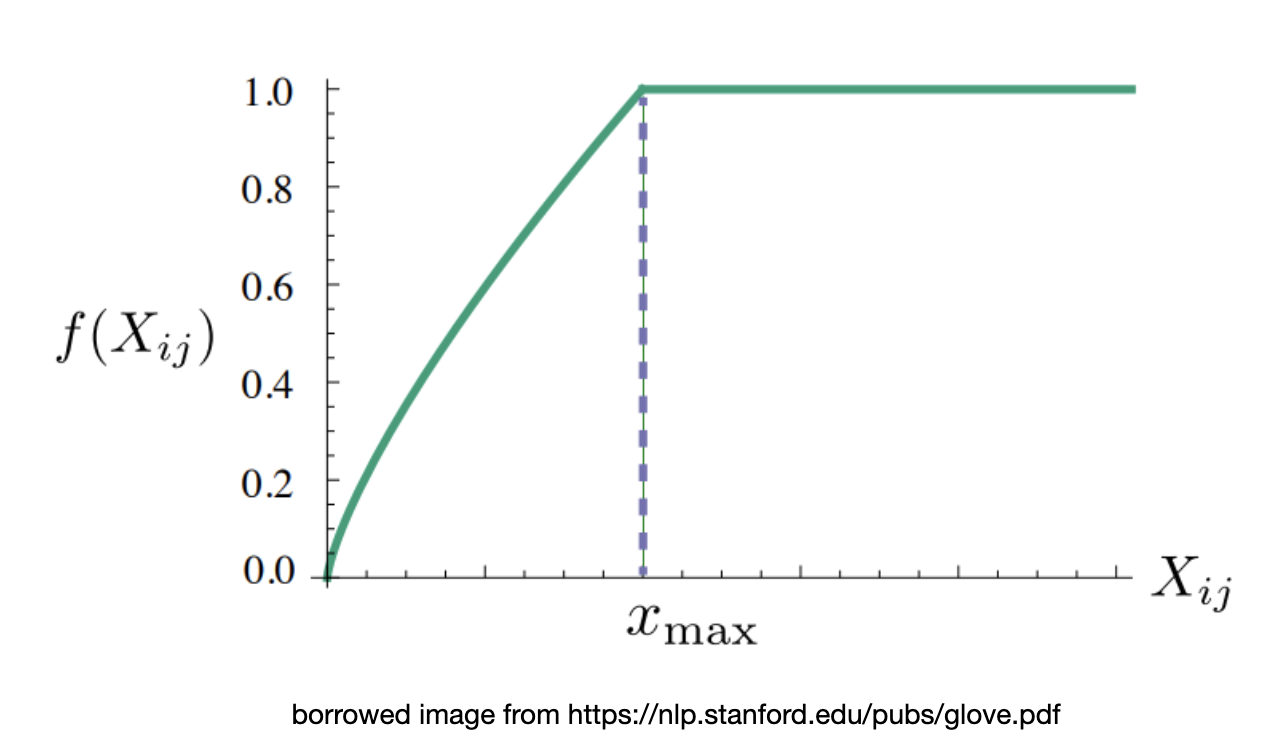

### Applying GloVe features for Machine Learning Tasks

- Let’s try and leverage GloVe based embeddings for our document clustering task. 
- The very popular spacy framework comes with capabilities to leverage GloVe embeddings based on different language models. 
- You can also get pre-trained word vectors and load them up as needed using gensim or spacy. 
- We will first install spacy and use the en_vectors_web_lg model which consists of 300-dimensional word vectors trained on Common Crawl with GloVe.

In [ ]:
#  python -m spacy download en_core_web_lg
import spacy

nlp = spacy.load('en_core_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

In [ ]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

We can now use t-SNE to visualize these embeddings similar to what we did using our Word2Vec embeddings.


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

The beauty of spacy is that it will automatically provide you the averaged embeddings for words in each document without having to implement a function like we did in Word2Vec. We will leverage the same to get document features for our corpus and use k-means clustering to cluster our documents.

In [ ]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

We see consistent clusters similar to what we obtained from our Word2Vec model which is good! The GloVe model claims to perform better than the Word2Vec model in many scenarios as illustrated in the following graph from the original paper by Pennington el al.

![](https://miro.medium.com/max/1136/1*M84ros1yMC7azUtUyJnONw.png)

## Applying FastText features for Machine Learning Tasks
- The gensim package has nice wrappers providing us interfaces to leverage the FastText model available under the gensim.models.fasttext module.
- Let’s apply this once again on our Bible corpus and look at our words of interest and their most similar words.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
from nltk.corpus import gutenberg
from string import punctuation

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)


In [ ]:
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

In [ ]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)
                    
                    
# view similar words based on gensim's FastText model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words                    

- You can see a lot of similarity in the results with our Word2Vec model with relevant similar words for each of our words of interest. 
- Do you notice any interesting associations and similarities?
![](https://miro.medium.com/max/868/1*-9s6TOw0lySpMQsMcDWPNA.png)

- Let’s now use Principal Component Analysis (PCA) to reduce the word embedding dimensions to 2-D and then visualize the same.

In [ ]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

- We can see a lot of interesting patterns! Noah, his son Shem and grandfather Methuselah are close to each other. 
- We also see God associated with Moses and Egypt where it endured the Biblical plagues including famine and pestilence. 
- Also Jesus and some of his disciples are associated close to each other.

- To access any of the word embeddings you can just index the model with the word as follows.

In [ ]:
ft_model.wv['jesus']

- Having these embeddings, we can perform some interesting natural language tasks. 
- One of these would be to find out similarity between different words (entities).

In [ ]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

- We can see that ‘god’ is more closely associated with ‘jesus’ rather than ‘satan’ based on the text in our Bible corpus. Quite relevant!

- Considering word embeddings being present, we can even find out odd words from a bunch of words as follows.

In [ ]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:',  
      ft_model.wv.doesnt_match(st1.split()))
st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', 
      ft_model.wv.doesnt_match(st2.split()))